In [7]:
!pip install einops


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


# Imports

In [1]:
import numpy as np
import pandas as pd
import transformers
import tensorflow as tf
import tqdm.notebook as tqdm
import sklearn.model_selection
import matplotlib.pyplot as plt

/home/bob1ch/Рабочий стол/NN-NLP/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'tensorflow'

In [1]:
import os
import math
import numpy as np
import pandas as pd
import transformers
from datasets import load_dataset
#import tensorflow as tf
import tqdm.notebook as tqdm
import sklearn.model_selection
import matplotlib.pyplot as plt

import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.decomposition import PCA

import torch
import torchvision
from torchinfo import summary

/home/bob1ch/Рабочий стол/NN-NLP/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device='cuda'

# Data

Load and prepare your dataset. Dataset should have at least 10k samples in it. Each dataset cannot be used by more than two students.

In [4]:
dataset = load_dataset('dair-ai/emotion')

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [780]:
dataset['train']['text'][3]

'i am ever feeling nostalgic about the fireplace i will know that it is still on the property'

In [3]:
class2idx = {'sadness': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5}
idx2class = {v:k for k,v in class2idx.items()}

# Backbone

Load pretrained model from Hugging Face (or some other model repository if it's more convenient). Model should be trained on Feature Extraction task.

In [5]:
#'michellejieli/emotion_text_classifier'

In [4]:
backbone = transformers.AutoModel.from_pretrained('jinaai/jina-embeddings-v3').to(device)

The repository for jinaai/jina-embeddings-v3 contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/jinaai/jina-embeddings-v3.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y
The repository for jinaai/jina-embeddings-v3 contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/jinaai/jina-embeddings-v3.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y\
The repository for jinaai/jina-embeddings-v3 contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/jinaai/jina-embeddings-v3.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Load tokenizer to be used with the model

In [5]:
tokenizer = transformers.AutoTokenizer.from_pretrained('jinaai/jina-embeddings-v3')

# Feature extraction

Since we will not be training the backbone, extract features from your dataset.

Tokenize all your sequences. Truncate/pad the squences for convenience. If the sequences are too large to be stored in memory, lazily save them on disk.

In [34]:
np.median(list(map(len, tokenizer(dataset['train']['text'])['input_ids'])))

np.float64(22.0)

In [35]:
tokenized_train = (tokenizer(dataset['train']['text'], return_tensors='pt', truncation=True, padding='max_length', max_length=22), dataset['train']['label'])
tokenized_val = (tokenizer(dataset['validation']['text'], return_tensors='pt', truncation=True, padding='max_length', max_length=22), dataset['validation']['label'])
tokenized_test = (tokenizer(dataset['test']['text'], return_tensors='pt', truncation=True, padding='max_length', max_length=22), dataset['test']['label'])

In [36]:
backbone(tokenized_train[0]['input_ids'][0:1]).pooler_output.shape

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [37]:
class Tokenized_dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X1 = torch.Tensor(X['input_ids']).to(device)
        self.y = torch.Tensor(y).to(device, dtype=torch.int32)
        
    def __getitem__(self, i):
        return self.X1[i], self.y[i]

    def __len__(self):
        return len(self.X1)

In [38]:
tokenizer_data = Tokenized_dataset(*tokenized_train)
tokenizer_data_loader = torch.utils.data.DataLoader(tokenizer_data, batch_size=256, shuffle=False)

vectorized_train = []
train_y = []

for i, batch in enumerate(tokenizer_data_loader):
    inp, y = batch
    vectorized_train.extend(backbone(inp).pooler_output.tolist())
    train_y.extend(y.tolist())
    print(f'{(i+1) / len(tokenizer_data_loader) * 100} %')

1.5873015873015872 %
3.1746031746031744 %
4.761904761904762 %
6.349206349206349 %
7.936507936507936 %
9.523809523809524 %
11.11111111111111 %
12.698412698412698 %
14.285714285714285 %
15.873015873015872 %
17.46031746031746 %
19.047619047619047 %
20.634920634920633 %
22.22222222222222 %
23.809523809523807 %
25.396825396825395 %
26.984126984126984 %
28.57142857142857 %
30.158730158730158 %
31.746031746031743 %
33.33333333333333 %
34.92063492063492 %
36.507936507936506 %
38.095238095238095 %
39.682539682539684 %
41.269841269841265 %
42.857142857142854 %
44.44444444444444 %
46.03174603174603 %
47.61904761904761 %
49.2063492063492 %
50.79365079365079 %
52.38095238095239 %
53.96825396825397 %
55.55555555555556 %
57.14285714285714 %
58.730158730158735 %
60.317460317460316 %
61.904761904761905 %
63.49206349206349 %
65.07936507936508 %
66.66666666666666 %
68.25396825396825 %
69.84126984126983 %
71.42857142857143 %
73.01587301587301 %
74.60317460317461 %
76.19047619047619 %
77.77777777777779 %
7

In [39]:
tokenizer_data = Tokenized_dataset(*tokenized_val)
tokenizer_data_loader = torch.utils.data.DataLoader(tokenizer_data, batch_size=256, shuffle=False)

vectorized_val = []
val_y = []

for i, batch in enumerate(tokenizer_data_loader):
    inp, y = batch
    vectorized_val.extend(backbone(inp).pooler_output.tolist())
    val_y.extend(y.tolist())
    print(f'{(i+1) / len(tokenizer_data_loader) * 100} %')

12.5 %
25.0 %
37.5 %
50.0 %
62.5 %
75.0 %
87.5 %
100.0 %


In [40]:
tokenizer_data = Tokenized_dataset(*tokenized_test)
tokenizer_data_loader = torch.utils.data.DataLoader(tokenizer_data, batch_size=256, shuffle=False)

vectorized_test = []
test_y = []

for i, batch in enumerate(tokenizer_data_loader):
    inp, y = batch
    vectorized_test.extend(backbone(inp).pooler_output.tolist())
    test_y.extend(y.tolist())
    print(f'{(i+1) / len(tokenizer_data_loader) * 100} %')

12.5 %
25.0 %
37.5 %
50.0 %
62.5 %
75.0 %
87.5 %
100.0 %


In [41]:
with open('train_vect.pkl', 'wb') as f:
    pickle.dump(vectorized_train, f)
with open('train_y.pkl', 'wb') as f:
    pickle.dump(train_y, f)

with open('val_vect.pkl', 'wb') as f:
    pickle.dump(vectorized_val, f)
with open('val_y.pkl', 'wb') as f:
    pickle.dump(val_y, f)

with open('test_vect.pkl', 'wb') as f:
    pickle.dump(vectorized_test, f)
with open('test_y.pkl', 'wb') as f:
    pickle.dump(test_y, f)

In [477]:
with open(r'train_vect.pkl', "rb") as input_file:
    vectorized_train = pickle.load(input_file)
with open(r'train_y.pkl', "rb") as input_file:
    train_y = pickle.load(input_file)

with open(r'val_vect.pkl', "rb") as input_file:
    vectorized_val = pickle.load(input_file)
with open(r'val_y.pkl', "rb") as input_file:
    val_y = pickle.load(input_file)

with open(r"test_vect.pkl", "rb") as input_file:
    vectorized_test = pickle.load(input_file)
with open(r"test_y.pkl", "rb") as input_file:
    test_y = pickle.load(input_file)

Run the backbone on the sequences and save the extracted features. The extracted features should be a vector containing information about the whole text. If the features are too large to be stored in memory, lazily save them on disk.

# Prepare train/test data

Split your data (extracted features and labels) into train and test subsets.

In [478]:
X_train, X_test, y_train, y_test = train_test_split(vectorized_train, train_y, shuffle=True, train_size=0.7)

Prepare `tf.data.Dataset` or some other way for the data to be used during training.

In [479]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = torch.Tensor(X).to(device, dtype=torch.float32)
        self.y = torch.LongTensor(y).to(device)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

    def __len__(self):
        return len(self.X)

In [480]:
train_data = Dataset(X_train, y_train)
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=512, shuffle=True)

val_data = Dataset(X_test, y_test)
val_data_loader = torch.utils.data.DataLoader(val_data, batch_size=512, shuffle=True)

# test_data = Dataset(vectorized_test, test_y)
# test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=True)

In [481]:
train_data = Dataset(vectorized_train, train_y)
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)

val_data = Dataset(vectorized_val, val_y)
val_data_loader = torch.utils.data.DataLoader(val_data, batch_size=128, shuffle=True)

test_data = Dataset(vectorized_test, test_y)
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=True)

# Build the model

Build a simple model. The model should accept an extracted feature vector and return a vector of class logits (or probabilities). Model should only have a couple (or even 1) layer with weights.

In [482]:
class Model(torch.nn.Module):
    def __init__(self, n_classes, backbone):
        super(Model, self).__init__()
        self.backbone = backbone
        self.L1 = torch.nn.LazyLinear(512)
        self.dropout = torch.nn.Dropout(0.4)
        self.classifier = torch.nn.LazyLinear(n_classes)

    def forward(self, x, inp_text):
        if inp_text is not None:
            x = self.backbone(inp_text).pooler_output.to(dtype=torch.float)
        x = self.dropout(x)
        x = self.L1(x)
        x = torch.nn.functional.relu(x)
        #x = torch.flatten(x)
        #x = x.view(x.shape[0], -1)
        x = self.dropout(x)
        out = self.classifier(x)
        return out

In [483]:
model = Model(len(np.unique(train_y)), backbone).to(device)

In [484]:
summary(model)

Layer (type:depth-idx)                                                           Param #
Model                                                                            559,364,096
├─XLMRobertaLoRA: 1-1                                                            --
│    └─XLMRobertaModel: 2-1                                                      --
│    │    └─XLMRobertaEmbeddings: 3-1                                            261,044,092
│    │    └─Dropout: 3-2                                                         --
│    │    └─LayerNorm: 3-3                                                       (2,048)
│    │    └─XLMRobertaEncoder: 3-4                                               310,173,696
│    │    └─XLMRobertaPooler: 3-5                                                1,090,560
├─LazyLinear: 1-2                                                                --
├─Dropout: 1-3                                                                   --
├─LazyLinear: 1-4               

Compile the model. Choose loss and metrics.

<BarContainer object of 6 artists>

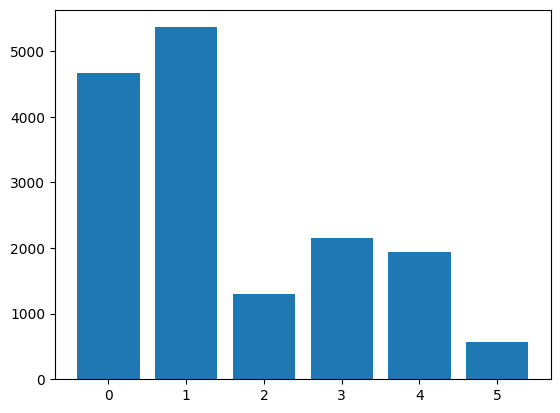

In [485]:
plt.bar(*np.unique(train_y, return_counts=True))

In [486]:
counts = torch.unique(torch.Tensor(train_y).to(device), return_counts=True)[-1] #торч требовал чтобы weights был torch.Tensor
weights = (1/counts) * (sum(counts) / len(counts))
weights

tensor([0.5715, 0.4973, 2.0450, 1.2351, 1.3767, 4.6620], device='cuda:0')

In [487]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#criterion = torch.nn.CrossEntropyLoss(weight=weights).to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)

# Train the model

In [488]:
def metric(y, y_logits):
    return ((y == y_logits.argmax(dim=-1)).sum() / len(y)).tolist()

In [489]:
def train_epoch(model, optimizer, criterion, data):
    model.train()
    total_loss = 0
    total_metric = 0

    for x, y in data:
        optimizer.zero_grad()
        y_pred = model(x, None)
        loss = criterion(y_pred, y)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_metric += metric(y, y_pred)

    return total_loss / len(data), total_metric / len(data)

In [490]:
def evaluate(model, criterion, data):
    model.eval()
    total_loss = 0
    total_metric = 0
    with torch.no_grad():
        for x, y in data:
            y_pred = model(x, None)
            loss = criterion(y_pred, y)
            total_loss += loss.item()
            total_metric += metric(y, y_pred)

    return total_loss / len(data), total_metric / len(data)

In [491]:
def train(model, optimizer, criterion, train_data, test_data, epochs, print_every=1):
    train_plot = []
    eval_plot = []
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    for epoch in range(epochs):
        train_loss, train_metric = train_epoch(model, optimizer, criterion, train_data)
        eval_loss, eval_metric = evaluate(model, criterion, test_data)
        #scheduler.step(eval_loss)
        train_plot.append(train_loss)
        eval_plot.append(eval_loss)
        if (epoch+1) % print_every == 0:
            print(f'EPOCH: {epoch+1}')
            print(f'TRAIN: {train_loss :.2f} loss | {train_metric * 100 :.2f}% metric')
            print(f'EVAL: {eval_loss :.2f} loss | {eval_metric * 100 :.2f}% metric')
            print(f'LR: {scheduler.get_last_lr()}')
            print('='*40)
            
    plt.plot(range(epochs), train_plot, label='train')
    plt.plot(range(epochs), eval_plot, label='val')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend()

EPOCH: 10
TRAIN: 0.92 loss | 65.87% metric
EVAL: 0.89 loss | 68.06% metric
LR: [0.001]
EPOCH: 20
TRAIN: 0.81 loss | 70.08% metric
EVAL: 0.84 loss | 68.57% metric
LR: [0.001]
EPOCH: 30
TRAIN: 0.73 loss | 72.94% metric
EVAL: 0.86 loss | 69.57% metric
LR: [0.001]
EPOCH: 40
TRAIN: 0.68 loss | 74.90% metric
EVAL: 0.85 loss | 69.09% metric
LR: [0.001]
EPOCH: 50
TRAIN: 0.64 loss | 76.52% metric
EVAL: 0.87 loss | 68.62% metric
LR: [0.001]


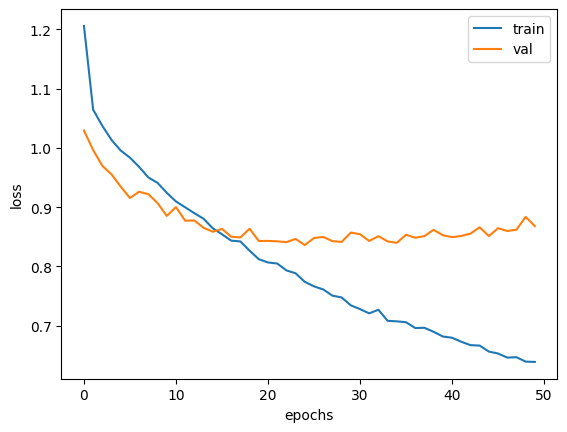

In [492]:
#здесь я применил веса и получилось хуже(
train(model, optimizer, criterion, train_data_loader, val_data_loader, 50, print_every=10)

EPOCH: 10
TRAIN: 0.61 loss | 77.33% metric
EVAL: 0.88 loss | 68.41% metric
LR: [0.001]
EPOCH: 20
TRAIN: 0.58 loss | 77.99% metric
EVAL: 0.89 loss | 68.28% metric
LR: [0.001]
EPOCH: 30
TRAIN: 0.56 loss | 79.09% metric
EVAL: 0.90 loss | 68.58% metric
LR: [0.001]
EPOCH: 40
TRAIN: 0.54 loss | 79.81% metric
EVAL: 0.93 loss | 68.06% metric
LR: [0.001]
EPOCH: 50
TRAIN: 0.53 loss | 80.26% metric
EVAL: 0.92 loss | 67.38% metric
LR: [0.001]


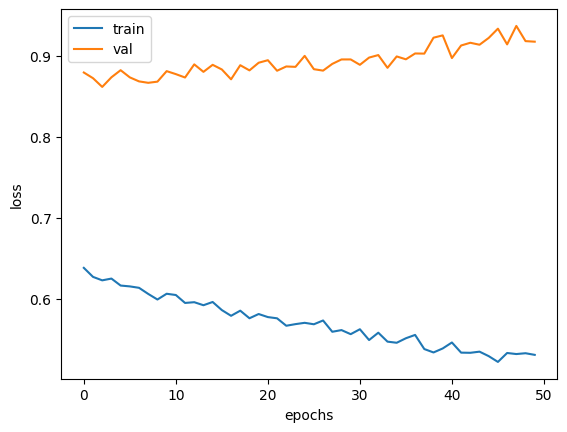

In [493]:
train(model, optimizer, criterion, train_data_loader, val_data_loader, 50, print_every=10)

# Evaluation

Evalute the model on test data.

In [494]:
print('TEST DATA: loss = {0:.2f}, metric = {1:.2f}%'.format(*evaluate(model, criterion, test_data_loader)))

TEST DATA: loss = 0.92, metric = 0.69%


Plot confusion matrix.

[Text(0, 0, 'sadness'),
 Text(0, 1, 'joy'),
 Text(0, 2, 'love'),
 Text(0, 3, 'anger'),
 Text(0, 4, 'fear'),
 Text(0, 5, 'surprise')]

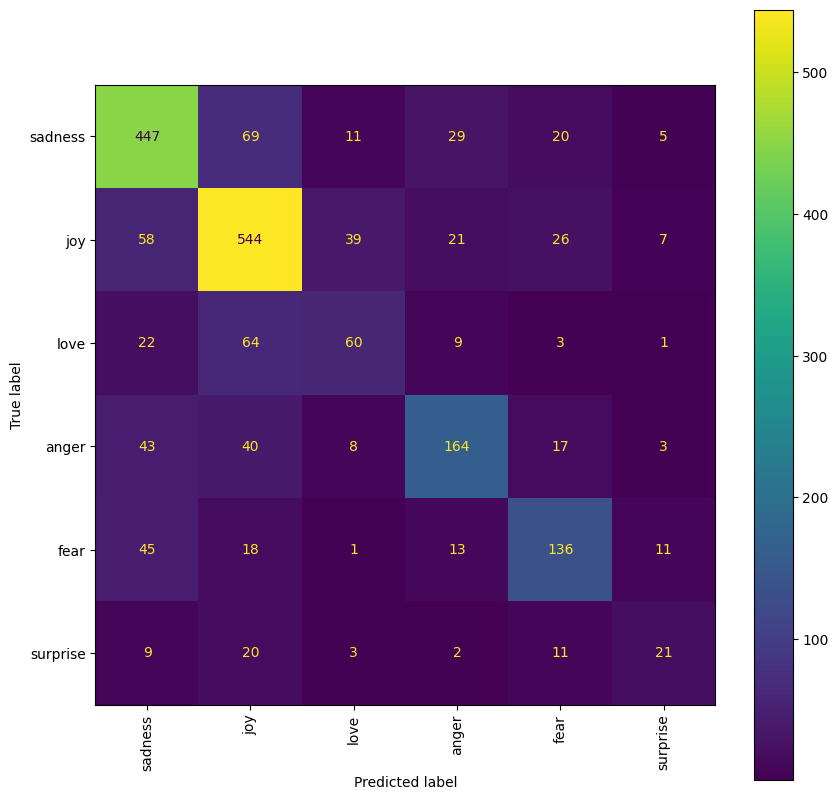

In [495]:
#vectorized_test, test_y
y_preds = model(torch.Tensor(vectorized_test).to(device), None).argmax(dim=-1)
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(test_y, y_preds.cpu(), ax=ax)
ax.xaxis.set_ticklabels(class2idx.keys())
ax.tick_params(axis='x', labelrotation=90)
ax.yaxis.set_ticklabels(class2idx.keys())

Write a function to classify a piece of text.

In [496]:
def classify_text(text: str) -> tuple[int | str, np.ndarray]:
    '''Classifes the given `text` using the trained model.

    Arguments:
        text: text to be classified

    Return:
        The assigned label and probabilites of all labels'''
    model.eval()
    text = tokenizer(text, return_tensors='pt')['input_ids'].to(device)
    res = model(None, text)
    return res.argmax(dim=-1).item()

Evaluate the model on text not present in training and test data (come up with the text yourself). Try to get an input for each class.

In [497]:
idx2class.values()

dict_values(['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])

In [498]:
corpus = ['Hello honey:)', 
          'Joker, are you mad?!', 
          'Happy birthday!', 
          'i miss my neighborhood',
          'Dad, check for monsters under the bed',
          'For the first time, this old fighter was surprised to feel tired',
          'It was a surprise!',
          'i love you',
          'i hate you',
          'i get good mark',]
for doc in corpus:
    print(f' "{doc}" are {idx2class[classify_text(doc)]} sentence')

 "Hello honey:)" are love sentence
 "Joker, are you mad?!" are joy sentence
 "Happy birthday!" are joy sentence
 "i miss my neighborhood" are love sentence
 "Dad, check for monsters under the bed" are fear sentence
 "For the first time, this old fighter was surprised to feel tired" are sadness sentence
 "It was a surprise!" are surprise sentence
 "i love you" are love sentence
 "i hate you" are sadness sentence
 "i get good mark" are joy sentence


# Bonus

Write a function that computes word impact on text label. 

In [505]:
def get_words_impact(text: str) -> list[tuple[str, np.ndarray]]:
    '''Determines word impact on text label.

    Arguments:
        text: Sample text to be used for computation.

    Returns:
        A list of pairs: the word and vector of probability changes for each class'''
    model.eval()
    words = text.split()
    
    res = []
    probs_orig = model(None, tokenizer(text, return_tensors='pt')['input_ids'].to(device))
    for word in words:
        text_without_word  = text.split().copy()
        text_without_word.remove(word)
        text_without_word = ''.join(text_without_word)
        text_without_word = tokenizer(text_without_word, return_tensors='pt')['input_ids'].to(device)
        probs = model(None, text_without_word)
        res.append((word, (torch.nn.functional.softmax(probs_orig) - torch.nn.functional.softmax(probs)).tolist()[0]))
    return res

In [503]:
get_words_impact(corpus[0])

/tmp/ipykernel_2183/1993269681.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  res.append((word, (torch.nn.functional.softmax(probs_orig - probs)).tolist()[0]))


[('Hello',
  [0.001425533089786768,
   0.27888214588165283,
   0.3780744969844818,
   0.07627654820680618,
   0.012480334378778934,
   0.252860963344574]),
 ('honey:)',
  [0.00027449335902929306,
   0.0074436175636947155,
   0.9915756583213806,
   0.0004835026920773089,
   0.00015986005018930882,
   6.282757385633886e-05])]

Try to find out words that make text have a specific label.

In [504]:
for doc in corpus:
    print(doc)
    pred_label = classify_text(doc)
    print(f'predicted label: {idx2class[pred_label]}')
    for word, vec in get_words_impact(doc):
        print(f' {" "*9}{[cls for cls in class2idx.keys()]}')
        print(f'{word:9} {[round(el, 3) for el in vec]}')
    print('='*40)

Hello honey:)
predicted label: love
          ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
Hello     [0.001, 0.279, 0.378, 0.076, 0.012, 0.253]
          ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
honey:)   [0.0, 0.007, 0.992, 0.0, 0.0, 0.0]
Joker, are you mad?!
predicted label: joy
          ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
Joker,    [0.168, 0.117, 0.277, 0.336, 0.093, 0.01]
          ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
are       [0.226, 0.04, 0.058, 0.6, 0.059, 0.018]
          ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
you       [0.526, 0.049, 0.031, 0.363, 0.023, 0.009]
          ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
mad?!     [0.018, 0.016, 0.076, 0.854, 0.014, 0.022]
Happy birthday!
predicted label: joy


/tmp/ipykernel_2183/1993269681.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  res.append((word, (torch.nn.functional.softmax(probs_orig - probs)).tolist()[0]))


          ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
Happy     [0.033, 0.062, 0.029, 0.271, 0.527, 0.078]
          ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
birthday! [0.362, 0.0, 0.0, 0.044, 0.559, 0.035]
i miss my neighborhood
predicted label: love
          ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
i         [0.113, 0.012, 0.849, 0.015, 0.008, 0.003]
          ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
miss      [0.09, 0.003, 0.901, 0.005, 0.001, 0.0]
          ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
my        [0.003, 0.003, 0.983, 0.004, 0.007, 0.0]
          ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
neighborhood [0.001, 0.001, 0.978, 0.003, 0.0, 0.017]
Dad, check for monsters under the bed
predicted label: fear
          ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
Dad,      [0.035, 0.082, 0.0, 0.002, 0.006, 0.875]
          ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
check 